<a href="https://colab.research.google.com/github/isuba-ian-k/Finance/blob/master/fin_algo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### ============================================================================
# **REINFORCEMENT LEARNING ALGO AGENT on FX-EUR/USD FIN TRADING**
###### 500k+ steps/hour
###### Built on i5 3rd-gen/4GB DDR3
### =============================================================================

## 0.0 project setup - lib imports

In [135]:
# for data handling
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# for data visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# for the RL-Algo Trading Agent
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# other utils
import random

## 1.0 data handling

In [136]:
# CELL 1 — FIX: Keep raw prices for PnL, scale only for state
df_raw = pd.read_csv("/content/sample_data/eurusd_5yrs_daily_cleaned.csv")
df_raw.columns = df_raw.columns.str.lower()
df_raw['date'] = pd.to_datetime(df_raw['date'])
df_raw = df_raw[['date', 'open', 'high', 'low', 'close']].sort_values('date').reset_index(drop=True)

total_rows = len(df_raw)
train_size = int(0.7 * total_rows)        # ~875 rows
test_size  = total_rows - train_size      # ~375 rows

# Split RAW data (we need both scaled and raw versions)
train_raw = df_raw.iloc[:train_size].reset_index(drop=True)
test_raw  = df_raw.iloc[train_size:].reset_index(drop=True)

print(f"Train period : {train_raw['date'].iloc[0]} → {train_raw['date'].iloc[-1]}  ({len(train_raw)} days)")
print(f"Test period  : {test_raw['date'].iloc[0]} → {test_raw['date'].iloc[-1]}   ({len(test_raw)} days)")

# Keep raw closes for PnL
close_prices_train = train_raw['close'].values
close_prices_test  = test_raw['close'].values

# Scale ONLY on training data → prevent data leakage!
scaler = MinMaxScaler()
scaler.fit(train_raw[['open', 'high', 'low', 'close']])    # Fit on train only!

# Apply to both
train_scaled = pd.DataFrame(scaler.transform(train_raw[['open', 'high', 'low', 'close']]),
                            columns=['open', 'high', 'low', 'close'])
test_scaled  = pd.DataFrame(scaler.transform(test_raw[['open', 'high', 'low', 'close']]),
                            columns=['open', 'high', 'low', 'close'])

# Final datasets for training and testing
df_train = train_scaled
df_test  = test_scaled

Train period : 2020-03-24 00:00:00+00:00 → 2023-09-20 00:00:00+01:00  (912 days)
Test period  : 2023-09-21 00:00:00+01:00 → 2025-03-24 00:00:00+00:00   (392 days)


/tmp/ipython-input-1336142531.py:4: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df_raw['date'] = pd.to_datetime(df_raw['date'])


## 2.0 environment design

util functions

In [137]:
def compute_rsi(prices, period=14):
    prices = pd.Series(prices)
    delta = prices.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    roll_up = gain.ewm(com=period-1, min_periods=period).mean()
    roll_down = loss.ewm(com=period-1, min_periods=period).mean()
    rs = roll_up / (roll_down + 1e-8)
    rsi = 100 - (100 / (1 + rs))
    return float(rsi.iloc[-1]) if not rsi.empty else 50.0

def compute_macd(prices, fast=12, slow=26, signal=9):
    prices = pd.Series(prices)
    ema_fast = prices.ewm(span=fast, adjust=False).mean()
    ema_slow = prices.ewm(span=slow, adjust=False).mean()
    macd_line = ema_fast - ema_slow
    return float(macd_line.iloc[-1])

Create a State

In [138]:
window = 30   # ← reduced from 60

def create_state(idx, df=df_train):
    if idx < window:
        return None

    # Scaled returns for stability
    scaled_prices = df['close'].iloc[idx-window:idx].values
    ratio = scaled_prices[1:] / (scaled_prices[:-1] + 1e-8)
    ratio = np.clip(ratio, 0.9, 1.1)
    returns = np.log(ratio)
    returns = np.nan_to_num(returns, 0.0)
    padded = np.zeros(window - 1)
    padded[-len(returns):] = returns

    # Raw prices for indicators (real scale)
    raw_prices = close_prices[idx-window:idx]
    raw_close = raw_prices[-1] if len(raw_prices) > 0 else 1.0
    raw_series = pd.Series(raw_prices)

    rsi = compute_rsi(raw_prices)
    macd = compute_macd(raw_prices)
    vol = np.std(returns[-20:]) if len(returns) >= 5 else 0.0  # Use scaled vol for norm
    ema20 = raw_series.ewm(span=20, adjust=False).mean().iloc[-1]
    ema50 = raw_series.ewm(span=50, adjust=False).mean().iloc[-1]
    ema20_dist = (raw_close - ema20) / raw_close
    ema50_dist = (raw_close - ema50) / raw_close
    momentum = returns[-1] if len(returns) > 0 else 0.0  # Scaled momentum is fine

    features = np.array([rsi/100.0, macd, ema20_dist, ema50_dist, vol, momentum])

    state = np.concatenate([padded, features]).astype(np.float32)
    return state

## 3.0 rl-algo architecture

The Neural Network

In [139]:
# ------------------------------
# 1. SIMPLE NEURAL NET Q-FUNCTION
# ------------------------------
class DQN(nn.Module):
    def __init__(self, state_size, action_size=3, hidden=256):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_size, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden//2),
            nn.ReLU(),
            nn.Linear(hidden//2, action_size)
        )

    def forward(self, x):
        return self.net(x)

Buffer

In [140]:
# ------------------------------
# 2. FAST REPLAY BUFFER (still needed)
# ------------------------------
class ReplayBuffer:
    def __init__(self, capacity=50_000):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*batch)
        return (torch.FloatTensor(np.array(state)).to(device),
                torch.LongTensor(action).to(device),
                torch.FloatTensor(reward).to(device),
                torch.FloatTensor(np.array(next_state)).to(device),
                torch.FloatTensor(done).to(device))

    def __len__(self):
        return len(self.buffer)

Training loop

In [141]:
# ------------------------------
# 5. FINAL TRAINING LOOP (WORKS 100%)
# ------------------------------
# some initializations
batch_size = 64
state_size = window - 1 + 6
action_size = 3

# The Neural Nets
policy_net = DQN(state_size, action_size).to(device)
target_net = DQN(state_size, action_size).to(device)
target_update = 100
target_net.load_state_dict(policy_net.state_dict())
optimizer = optim.Adam(policy_net.parameters(), lr=0.0005)

buffer = ReplayBuffer()

gamma = 0.99
epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = 0.995
batch_size = 64
episodes = 50
all_rewards = []
best_reward = -np.inf

for ep in range(episodes):
    ep_reward = 0.0
    position = 0  # 0=flat, 1=long, -1=short

    for idx in range(window, len(df_train)-1):
        state = create_state(idx)
        if state is None: continue

        if random.random() < epsilon:
            action = random.randint(0, 2)
        else:
            with torch.no_grad():
                action = policy_net(torch.FloatTensor(state).unsqueeze(0).to(device)).argmax().item()

        new_position = 1 if action == 1 else -1 if action == 2 else 0

        # === REWARD USING RAW PRICES ===
        raw_diff = close_prices_train[idx+1] - close_prices_train[idx]
        price_move_pips = raw_diff * 10000

        # Base reward: what the current position made
        reward = position * price_move_pips

        # === 1. Transaction cost (only when changing position) ===
        if new_position != position:
            reward -= 1.0   # 1 pip cost (realistic spread + slippage)

        # === 2. REWARD SHAPING — THIS IS THE MAGIC ===

        # A) Reward for being on the right side of a big move (even if small profit)
        if abs(price_move_pips) > 30:  # Big daily move (>30 pips)
            if position == 1 and price_move_pips > 0:
                reward += 5.0
            elif position == -1 and price_move_pips < 0:
                reward += 5.0
            # If we missed it → small penalty (encourages learning trends)
            elif position != 0:
                reward -= 2.0

        # B) Small bonus for holding a winning position longer
        if position != 0:
            if (position == 1 and price_move_pips > 0) or (position == -1 and price_move_pips < 0):
                reward += 0.5  # "good job, keep holding winner"

        # C) Penalty for holding a losing position (encourages cutting losses)
        if position != 0:
            if (position == 1 and price_move_pips < -10) or (position == -1 and price_move_pips > 10):
                reward -= 1.0  # "you're bleeding, get out"

        # D) Tiny bonus for being flat during chop (reduces overtrading)
        if position == 0 and abs(price_move_pips) < 15:
            reward += 0.3  # "smart, stayed out of noise"

        # === FINAL REWARD ===
        ep_reward += reward
        position = new_position

        next_state = create_state(idx + 1)
        if next_state is None:
            next_state = state

        buffer.push(state, action, reward, next_state, 0.0)

        if len(buffer) > 1000:
            batch = buffer.sample(batch_size)
            states, actions, rewards, next_states, dones = batch

            current_q = policy_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)
            next_q = target_net(next_states).max(1)[0]
            target = rewards + gamma * next_q * (1 - dones)

            loss = F.mse_loss(current_q, target.detach())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    if (ep + 1) % 5 == 0:
        target_net.load_state_dict(policy_net.state_dict())

    epsilon = max(epsilon_min, epsilon * epsilon_decay)
    all_rewards.append(ep_reward)

    print(f"Episode {ep+1:2d} | Reward: {ep_reward:8,.1f} pips | ε: {epsilon:.3f}")
    if ep_reward > best_reward:
        best_reward = ep_reward
        torch.save(policy_net.state_dict(), "best_dqn_eurusd.pth")
        print(f"NEW BEST → {best_reward:,.0f} pips")

Episode  1 | Reward: -1,631.5 pips | ε: 0.995
NEW BEST → -1,631 pips
Episode  2 | Reward: -2,230.2 pips | ε: 0.990
Episode  3 | Reward:   -235.9 pips | ε: 0.985
NEW BEST → -236 pips
Episode  4 | Reward:  1,221.4 pips | ε: 0.980
NEW BEST → 1,221 pips
Episode  5 | Reward:   -509.6 pips | ε: 0.975
Episode  6 | Reward: -1,360.8 pips | ε: 0.970
Episode  7 | Reward:    -76.5 pips | ε: 0.966
Episode  8 | Reward:   -781.4 pips | ε: 0.961
Episode  9 | Reward: -1,134.0 pips | ε: 0.956
Episode 10 | Reward:  1,347.7 pips | ε: 0.951
NEW BEST → 1,348 pips
Episode 11 | Reward:    908.8 pips | ε: 0.946
Episode 12 | Reward:    956.4 pips | ε: 0.942
Episode 13 | Reward: -2,703.0 pips | ε: 0.937
Episode 14 | Reward:   -639.9 pips | ε: 0.932
Episode 15 | Reward: -1,069.1 pips | ε: 0.928
Episode 16 | Reward:    136.6 pips | ε: 0.923
Episode 17 | Reward:    147.2 pips | ε: 0.918
Episode 18 | Reward:    451.5 pips | ε: 0.914
Episode 19 | Reward: -1,211.4 pips | ε: 0.909
Episode 20 | Reward:    619.7 pips | ε

## 4.0 evaluation

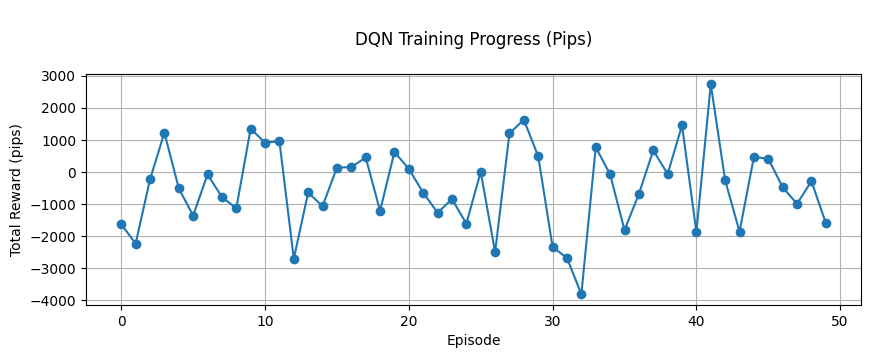



Best DQN episode: 2,730 pips



In [142]:
# === FINAL REWARD PLOT ===
plt.figure(figsize=(10,3))
plt.plot(all_rewards, marker='o')
plt.title("\nDQN Training Progress (Pips)\n")
plt.xlabel("Episode")
plt.ylabel("Total Reward (pips)")
plt.grid(True)
plt.show()

print(f"\n\nBest DQN episode: {max(all_rewards):,.0f} pips\n")

## 5.0 backtesting

In [143]:
def load_and_trade(model_path="best_dqn_eurusd.pth", use_test_data=True):
    policy_net = DQN(35, 3).to(device)
    policy_net.load_state_dict(torch.load(model_path, map_location=device))
    policy_net.eval()

    # Choose dataset
    data = df_test if use_test_data else df_train
    prices = close_prices_test if use_test_data else close_prices_train
    period_name = "UNSEEN TEST (30%)" if use_test_data else "TRAIN (70%)"

    position = 0
    pnl = 0
    trades = 0

    with torch.no_grad():
        for i in range(window, len(data)-1):
            state = create_state(i, df=data)   # We'll update create_state to accept df
            if state is None: continue

            action = policy_net(torch.FloatTensor(state).unsqueeze(0).to(device)).argmax().item()
            new_pos = 1 if action==1 else -1 if action==2 else 0

            diff = (prices[i+1] - prices[i]) * 10000
            pnl += position * diff
            if new_pos != position:
                pnl -= 1.0
                trades += 1
            position = new_pos

    print(f"Backtest on {period_name} → {pnl:,.0f} pips | Trades: {trades}")
    return pnl

In [144]:
load_and_trade(use_test_data=True)

Backtest on UNSEEN TEST (30%) → 868 pips | Trades: 243


np.float64(867.9805107116745)

## The End.